# Tutorial 6: Mixed Precision Quantization Search with Mase and Optuna

In this tutorial, we'll see how Mase can be integrated with Optuna, the popular hyperparameter optimization framework, to search for a Bert model optimized for sequence classification on the IMDb dataset. We'll take the Optuna-generated model and import it into Mase, then run the CompressionPipeline to prepare the model for edge deployment by quantizing and pruning its weights.

As we'll see, running Architecture Search with Mase/Optuna involves the following steps.

1. **Define the search space**: this is a dictionary containing the range of values for each parameter at each layer in the model.

2. **Write the model constructor**: this is a function which uses Optuna utilities to sample a model from the search space, and constructs the model using transformers from_config class method.

3. **Write the objective function**: this function calls on the model constructor defined in Step 2 and defines the training/evaluation setup for each search iteration.

4. **Go!** Choose an Optuna sampler, create a study and launch the search.

In [1]:
checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

## Importing the model

If you are starting from scratch, you can load the Bert checkpoint directly from HuggingFace.

In [2]:
from transformers import AutoModel

model = AutoModel.from_pretrained(checkpoint)

If you have previously ran the tutorial on Neural Architecture Search (NAS), run the following cell to import the best model obtained from the search process.

In [ ]:
from pathlib import Path
import dill

with open(f"{Path.home()}/tutorial_5_best_model.pkl", "rb") as f:
    base_model = dill.load(f)

First, fetch the dataset using the `get_tokenized_dataset` utility.

In [ ]:
from chop.tools import get_tokenized_dataset

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

## 1. Defining the Search Space

We'll start by defining a search space, i.e. enumerating the possible combinations of hyperparameters that Optuna can choose during search. We'll explore the following range of values for the model's hidden size, intermediate size, number of layers and number of heads.

In [5]:
import torch
from chop.nn.quantized.modules.linear import (
    LinearInteger,
    LinearMinifloatDenorm,
    LinearMinifloatIEEE,
    LinearLog,
    LinearBlockFP,
    LinearBlockMinifloat,
    LinearBlockLog,
    LinearBinary,
    LinearBinaryScaling,
    LinearBinaryResidualSign,
)

search_space = {
    "linear_layer_choices": [
        torch.nn.Linear,
        LinearInteger,
    ],
}

## 2. Writing a Model Constructor

We define the following function, which will get called in each iteration of the search process. The function is passed the `trial` argument, which is an Optuna object that comes with many functionalities - see the [Trial documentation](https://optuna.readthedocs.io/en/stable/reference/trial.html) for more details. Here, we use the `trial.suggest_categorical` function, which triggers the chosen sampler to choose a layer type. The suggested integer is the index into the search space for each parameter, which we defined in the previous cell.

In [6]:
from chop.tools.utils import deepsetattr
from copy import deepcopy


def construct_model(trial):

    # Fetch the model
    trial_model = deepcopy(base_model)

    # Quantize layers according to optuna suggestions
    for name, layer in trial_model.named_modules():
        if isinstance(layer, torch.nn.Linear):
            new_layer_cls = trial.suggest_categorical(
                f"{name}_type",
                search_space["linear_layer_choices"],
            )

            if new_layer_cls == torch.nn.Linear:
                continue

            kwargs = {
                "in_features": layer.in_features,
                "out_features": layer.out_features,
            }

            # If the chosen layer is integer, define the low precision config
            if new_layer_cls == LinearInteger:
                kwargs["config"] = {
                    "data_in_width": 8,
                    "data_in_frac_width": 4,
                    "weight_width": 8,
                    "weight_frac_width": 4,
                    "bias_width": 8,
                    "bias_frac_width": 4,
                }
            # elif... (other precisions)

            # Create the new layer (copy the weights)
            new_layer = new_layer_cls(**kwargs)
            new_layer.weight.data = layer.weight.data

            # Replace the layer in the model
            deepsetattr(trial_model, name, new_layer)

    return trial_model

## 3. Defining the Objective Function

Next, we define the objective function for the search, which gets called on each trial. In each trial, we create a new model instace with chosen hyperparameters according to the defined sampler. We then use the `get_trainer` utility in Mase to run a training loop on the IMDb dataset for a number of epochs. Finally, we use `evaluate` to report back the classification accuracy on the test split.

In [7]:
from chop.tools import get_trainer
import random


def objective(trial):

    # Define the model
    model = construct_model(trial)

    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )

    trainer.train()
    eval_results = trainer.evaluate()

    trial.set_user_attr("model", model)

    return eval_results["eval_accuracy"]

## 4. Launching the Search

Optuna provides a number of samplers, for example:

* **GridSampler**: iterates through every possible combination of hyperparameters in the search space
* **RandomSampler**: chooses a random combination of hyperparameters in each iteration
* **TPESampler**: uses Tree-structured Parzen Estimator algorithm to choose hyperparameter values.

You can define the chosen sampler by simply importing from `optuna.samplers` as below.

In [8]:
from optuna.samplers import GridSampler, RandomSampler, TPESampler

sampler = RandomSampler()

With all the pieces in place, we can launch the search as follows. The number of trials is set to 1 so you can go get a coffee for 10 minutes, then proceed with the tutorial. However, this will essentially be a random model - for better results, set this to 100 and leave it running overnight!

In [ ]:
import optuna

study = optuna.create_study(
    direction="maximize",
    study_name="bert-tiny-nas-study",
    sampler=sampler,
)

study.optimize(
    objective,
    n_trials=1,
    timeout=60 * 60 * 24,
)

# Task 1

In [ ]:
import torch
from chop.nn.quantized.modules.linear import (
    LinearInteger,
    LinearMinifloatDenorm,
    LinearMinifloatIEEE,
    LinearLog,
    LinearBlockFP,
    LinearBlockMinifloat,
    LinearBlockLog,
    LinearBinary,
    LinearBinaryScaling,
    LinearBinaryResidualSign,
)
from chop.tools.utils import deepsetattr
from chop.tools import get_trainer
from copy import deepcopy
import optuna
from optuna.samplers import TPESampler
import matplotlib.pyplot as plt






# Define the search space
search_space = {
    "linear_layer_choices": [
        torch.nn.Linear,
        LinearInteger,
    ],
    "width_choices": [8, 16, 32],
    "fractional_width_choices": [2, 4, 8],
}





# Construct the model with quantized layers
def construct_model(trial):
    trial_model = deepcopy(base_model)

    for name, layer in trial_model.named_modules():
        if isinstance(layer, torch.nn.Linear):
            # Choose the type of linear layer
            new_layer_cls = trial.suggest_categorical(
                f"{name}_type",
                search_space["linear_layer_choices"],
            )

            if new_layer_cls == torch.nn.Linear:
                continue

            # Define the widths and fractional widths
            data_in_width = trial.suggest_categorical(f"{name}_data_in_width", search_space["width_choices"])
            data_in_frac_width = trial.suggest_categorical(f"{name}_data_in_frac_width", search_space["fractional_width_choices"])
            weight_width = trial.suggest_categorical(f"{name}_weight_width", search_space["width_choices"])
            weight_frac_width = trial.suggest_categorical(f"{name}_weight_frac_width", search_space["fractional_width_choices"])
            bias_width = trial.suggest_categorical(f"{name}_bias_width", search_space["width_choices"])
            bias_frac_width = trial.suggest_categorical(f"{name}_bias_frac_width", search_space["fractional_width_choices"])

            kwargs = {
                "in_features": layer.in_features,
                "out_features": layer.out_features,
                "config": {
                    "data_in_width": data_in_width,
                    "data_in_frac_width": data_in_frac_width,
                    "weight_width": weight_width,
                    "weight_frac_width": weight_frac_width,
                    "bias_width": bias_width,
                    "bias_frac_width": bias_frac_width,
                },
            }

            # Create the new layer (copy the weights)
            new_layer = new_layer_cls(**kwargs)
            new_layer.weight.data = layer.weight.data

            # Replace the layer in the model
            deepsetattr(trial_model, name, new_layer)

    return trial_model






from chop.tools import get_trainer
import random


def objective(trial):

    # Define the model
    model = construct_model(trial)

    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )

    trainer.train()
    eval_results = trainer.evaluate()

    trial.set_user_attr("model", model)

    return eval_results["eval_accuracy"]




# Run the Optuna search
sampler = TPESampler()
study = optuna.create_study(direction="maximize", sampler=sampler, study_name="bert-tiny-nas-study")
study.optimize(objective, n_trials=10, timeout=60 * 60* 24)

# Plot the results
trial_numbers = [i for i in range(1, len(study.trials) + 1)]
max_accuracies = [max([t.value for t in study.trials[:i] if t.value is not None]) for i in trial_numbers]

plt.figure(figsize=(10, 6))
plt.plot(trial_numbers, max_accuracies, marker="o", label="Max Accuracy")
plt.title("Optuna Search: Maximum Achieved Accuracy Per Trial")
plt.xlabel("Number of Trials")
plt.ylabel("Maximum Accuracy")
plt.grid(True)
plt.legend()
plt.show()




![Linear Precision](/Users/matthieubou/Desktop/ADL/Cloned%20Repository/mase/docs/source/modules/documentation/tutorials/Tutorial%20Images/Tutorial%206/LinearPrecision.png)



# Code with the Cost and select either nn.Linear or other Precisions 

In [ ]:

import random
import dill
from copy import deepcopy
from pathlib import Path

import torch
import pandas as pd
import matplotlib.pyplot as plt

import optuna
from optuna.samplers import TPESampler

from transformers import AutoModel
from chop.tools import get_tokenized_dataset, get_trainer
from chop.tools.utils import deepsetattr

# Import supported linear quantizers.
from torch import nn
from chop.nn.quantized.modules.linear import (
    LinearInteger,
    LinearMinifloatDenorm,
    LinearMinifloatIEEE,
    LinearLog,
    LinearBlockFP,
    LinearBlockMinifloat,
    LinearBlockLog,
    LinearBinary,
    LinearBinaryScaling,
    # LinearBinaryResidualSign,  # Ignored as per professor's suggestion.
)

# ------------------------------------------------------------------------------
# Configuration: Checkpoints, dataset, etc.
checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

# Load the floating-point base model.
model = AutoModel.from_pretrained(checkpoint)
with open("/content/best_tpe_model.pkl", "rb") as f:
    base_model = dill.load(f)

# Get tokenized dataset and tokenizer.
dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

# ------------------------------------------------------------------------------
# Define the list of precision types you want to test.
# (You can include nn.Linear if desired.)
precision_choices = [
    nn.Linear,  # Full precision (if you want to include it)
    #LinearInteger,  DONE 
    # LinearMinifloatDenorm,  
    # LinearMinifloatIEEE,
    # LinearLog,
    # LinearBlockFP,
    # LinearBlockMinifloat,  # Uncomment if desired.
    LinearBlockLog,
    # LinearBinary,
    # LinearBinaryScaling,
]

# Allowed choices for widths and fractional widths.
width_choices = [8, 16, 32]
frac_width_choices = [2, 4, 8]

# ------------------------------------------------------------------------------

def construct_model_fixed(trial, chosen_precision):
    """
    Constructs a new model where each nn.Linear layer is randomly chosen
    between full precision (nn.Linear) or one of the quantized types.
    """

    trial_model = deepcopy(base_model)

    for name, layer in trial_model.named_modules():
        if isinstance(layer, nn.Linear):
          # Choose precision type for this specific layer
            chosen_precision = trial.suggest_categorical(
                f"{name}_precision",
                precision_choices  # nn.Linear + all quantized layers
            )
            
            kwargs = {
                "in_features": layer.in_features,
                "out_features": layer.out_features,
            }

            # Depending on the chosen precision, create a configuration.
            if chosen_precision == LinearInteger:
                config = {
                    "weight_width": trial.suggest_categorical(f"{name}_weight_width", width_choices),
                    "weight_frac_width": trial.suggest_categorical(f"{name}_weight_frac_width", frac_width_choices),
                    "data_in_width": trial.suggest_categorical(f"{name}_data_in_width", width_choices),
                    "data_in_frac_width": trial.suggest_categorical(f"{name}_data_in_frac_width", frac_width_choices),
                    "bias_width": trial.suggest_categorical(f"{name}_bias_width", width_choices),
                    "bias_frac_width": trial.suggest_categorical(f"{name}_bias_frac_width", frac_width_choices),
                    "floor": False,
                }
            elif chosen_precision in [LinearMinifloatDenorm, LinearMinifloatIEEE]:
                config = {
                    "weight_width": trial.suggest_categorical(f"{name}_weight_width", width_choices),
                    "weight_exponent_width": 5,
                    "weight_exponent_bias": 15,
                    "data_in_width": trial.suggest_categorical(f"{name}_data_in_width", width_choices),
                    "data_in_exponent_width": 5,
                    "data_in_exponent_bias": 15,
                    "bias_width": trial.suggest_categorical(f"{name}_bias_width", width_choices),
                    "bias_exponent_width": 5,
                    "bias_exponent_bias": 15,
                }
            elif chosen_precision == LinearLog:
                config = {
                    "weight_width": trial.suggest_categorical(f"{name}_weight_width", width_choices),
                    "weight_exponent_bias": 0,
                    "data_in_width": trial.suggest_categorical(f"{name}_data_in_width", width_choices),
                    "data_in_exponent_bias": 0,
                    "bias_width": trial.suggest_categorical(f"{name}_bias_width", width_choices),
                    "bias_exponent_bias": 0,
                }
            elif chosen_precision == LinearBlockFP:
                config = {
                    "weight_width": trial.suggest_categorical(f"{name}_weight_width", width_choices),
                    "weight_exponent_width": 5,
                    "weight_exponent_bias": 15,
                    "weight_block_size": [16],  # kept fixed for now.
                    "data_in_width": trial.suggest_categorical(f"{name}_data_in_width", width_choices),
                    "data_in_exponent_width": 5,
                    "data_in_exponent_bias": 15,
                    "data_in_block_size": [16],
                    "data_in_skip_first_dim": True,
                    "bias_width": trial.suggest_categorical(f"{name}_bias_width", width_choices),
                    "bias_exponent_width": 5,
                    "bias_exponent_bias": 15,
                    "bias_block_size": [16],
                }
            elif chosen_precision == LinearBlockLog:
                config = {
                    "weight_width": trial.suggest_categorical(f"{name}_weight_width", width_choices),
                    "weight_exponent_bias_width": 0,
                    "weight_block_size": [16],
                    "data_in_width": trial.suggest_categorical(f"{name}_data_in_width", width_choices),
                    "data_in_exponent_bias_width": 0,
                    "data_in_block_size": [16],
                    "data_in_skip_first_dim": True,
                    "bias_width": trial.suggest_categorical(f"{name}_bias_width", width_choices),
                    "bias_exponent_bias_width": 0,
                    "bias_block_size": [16],
                }
            elif chosen_precision == LinearBinary:
                config = {
                    "weight_stochastic": False,
                    "weight_bipolar": True,
                }
            elif chosen_precision == LinearBinaryScaling:
                config = {
                    "data_in_stochastic": False,
                    "bias_stochastic": False,
                    "weight_stochastic": False,
                    "data_in_bipolar": True,
                    "bias_bipolar": True,
                    "weight_bipolar": True,
                    "binary_training": True,
                }
            else:
                config = {}

            # Create the new layer.
            new_layer = chosen_precision(**kwargs, config=config)
            new_layer.weight.data = layer.weight.data.clone()
            if layer.bias is not None:
                new_layer.bias.data = layer.bias.data.clone()
            deepsetattr(trial_model, name, new_layer)

    return trial_model

    """Optuna selects whether to keep it as nn.Linear or replace it with a quantized version.
If it's a quantized layer, Optuna also selects the hyperparameters (e.g., bit width, exponent bias)."""

# ------------------------------------------------------------------------------

from chop.passes.graph import MaseGraph
from chop.passes.graph.analysis.quantization.calculate_avg_bits import calculate_avg_bits_mg_analysis_pass

def get_avg_bits_from_model(model):
    """
    Converts a model into a MaseGraph and computes the average number of bits spent 
    on weights and activations using calculate_avg_bits_mg_analysis_pass.
    
    :param model: The PyTorch model to analyze.
    :return: Average bits per activation and weight.
    """
    # Convert model to a MaseGraph
    graph = MaseGraph.from_model(model)

    # Run the bit analysis
    analyzed_graph, bit_info = calculate_avg_bits_mg_analysis_pass(graph, pass_args={})

    # Extract values
    data_avg_bit = bit_info["data_avg_bit"]
    w_avg_bit = bit_info["w_avg_bit"]

    return data_avg_bit, w_avg_bit


# ------------------------------------------------------------------------------
def objective(trial):
    # Construct the model with mixed precision layers
    model = construct_model_mixed(trial)
    
    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )
    
    trainer.train()
    eval_results = trainer.evaluate()
    
    # Compute average bits used for activations & weights
    data_avg_bit, w_avg_bit = get_avg_bits_from_model(model)

    # Define cost weight (λ) to balance accuracy and efficiency
    lambda_factor = 0.01  # Adjust based on experiments

    # Total bit cost (considering both weights & activations)
    total_bit_cost = (data_avg_bit + w_avg_bit)

    # Adjusted objective score
    adjusted_score = eval_results["eval_accuracy"] - lambda_factor * total_bit_cost

    # Store bit usage as trial attributes
    trial.set_user_attr("data_avg_bit", data_avg_bit)
    trial.set_user_attr("w_avg_bit", w_avg_bit)

    return adjusted_score


# ------------------------------------------------------------------------------
def run_study_for_precision(chosen_precision, n_trials=15):
    """Runs an Optuna study for a fixed precision type."""
    sampler = TPESampler()
    study_name = f"study_{chosen_precision.__name__}" if chosen_precision != nn.Linear else "study_FullPrecision"
    study = optuna.create_study(direction="maximize", study_name=study_name, sampler=TPESampler())

    # Optimize the study with a lambda that fixes the chosen precision.
    study.optimize(lambda trial: objective(trial, chosen_precision),
                   n_trials=n_trials,
                   timeout=60 * 60 * 24)  # adjust timeout as needed

    # Gather results into a DataFrame.
    results = []
    for t in sorted(study.trials, key=lambda t: t.number):
        results.append({
            "trial_number": t.number,
            "trial_accuracy": t.value,
            "precision_type": t.user_attrs.get("precision_type", "Unknown")
        })

    df = pd.DataFrame(results)
    csv_name = f"optuna_results_{chosen_precision.__name__ if chosen_precision != nn.Linear else 'FullPrecision'}.csv"
    df.to_csv(csv_name, index=False)
    print(f"Results for precision {chosen_precision.__name__ if chosen_precision != nn.Linear else 'FullPrecision'} saved to {csv_name}")
    return df


# ------------------------------------------------------------------------------
# Run studies for each precision type sequentially.
all_results = []  # to store all results for final plotting

for prec in precision_choices:
    print(f"\nRunning study for precision type: {prec.__name__ if prec != nn.Linear else 'FullPrecision'}")
    df_prec = run_study_for_precision(prec, n_trials=15)
    # Append a column to mark the precision type.
    df_prec["precision_type"] = prec.__name__ if prec != nn.Linear else "FullPrecision"
    all_results.append(df_prec)

    # (Optional) Plot the cumulative best accuracy for this precision type.
    df_prec = df_prec.sort_values("trial_number")
    trial_nums = df_prec["trial_number"].tolist()
    accuracies = df_prec["trial_accuracy"].tolist()
    cum_best = []
    current_best = -float("inf")
    for acc in accuracies:
        current_best = max(current_best, acc)
        cum_best.append(current_best)
    plt.figure(figsize=(6,4))
    plt.plot(trial_nums, cum_best, marker="o", label=prec.__name__ if prec != nn.Linear else "FullPrecision")
    plt.xlabel("Trial Number")
    plt.ylabel("Cumulative Best Accuracy")
    plt.title(f"Optimization Progress for {prec.__name__ if prec != nn.Linear else 'FullPrecision'}")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"optuna_progress_{prec.__name__ if prec != nn.Linear else 'FullPrecision'}.png")
    plt.show()

# ------------------------------------------------------------------------------
# Combine all results and plot one figure with one curve per precision type.
combined_df = pd.concat(all_results, ignore_index=True)

plt.figure(figsize=(10, 6))
# Group results by precision type.
for precision, group in combined_df.groupby("precision_type"):
    group = group.sort_values("trial_number")
    trial_nums = group["trial_number"].tolist()
    accuracies = group["trial_accuracy"].tolist()

    cum_best = []
    current_best = -float("inf")
    for acc in accuracies:
        current_best = max(current_best, acc)
        cum_best.append(current_best)
    plt.plot(trial_nums, cum_best, marker="o", label=precision)

plt.xlabel("Trial Number")
plt.ylabel("Cumulative Best Accuracy")
plt.title("Optimization Progress by Precision Type (5 Trials Each)")
plt.legend(title="Precision Type")
plt.grid(True)
plt.savefig("optuna_combined_precision_progress.png")
plt.show()

# Save the combined results to CSV.
combined_df.to_csv("optuna_combined_results.csv", index=False)
print("Combined results saved to optuna_combined_results.csv")

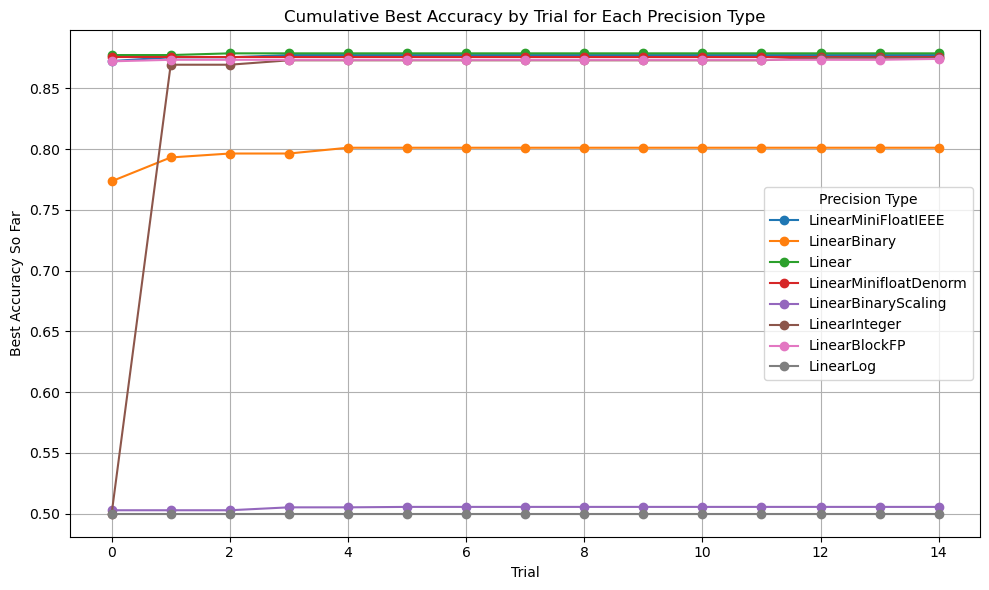

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the data as a NumPy array
raw_data = np.array([
    ["LinearMiniFloatIEEE", 0, 0.87252], ["LinearMiniFloatIEEE", 1, 0.87564],
    ["LinearMiniFloatIEEE", 2, 0.87356], ["LinearMiniFloatIEEE", 3, 0.87744],
    ["LinearMiniFloatIEEE", 4, 0.87304], ["LinearMiniFloatIEEE", 5, 0.87536],
    ["LinearMiniFloatIEEE", 6, 0.87424], ["LinearMiniFloatIEEE", 7, 0.87496],
    ["LinearMiniFloatIEEE", 8, 0.87468], ["LinearMiniFloatIEEE", 9, 0.87612],
    ["LinearMiniFloatIEEE", 10, 0.87352], ["LinearMiniFloatIEEE", 11, 0.87556],
    ["LinearMiniFloatIEEE", 12, 0.87544], ["LinearMiniFloatIEEE", 13, 0.87224],
    ["LinearMiniFloatIEEE", 14, 0.87352],
    ["LinearBinary", 0, 0.7736], ["LinearBinary", 1, 0.7932],
    ["LinearBinary", 2, 0.79644], ["LinearBinary", 3, 0.77668],
    ["LinearBinary", 4, 0.8012], ["LinearBinary", 5, 0.77876],
    ["LinearBinary", 6, 0.7852], ["LinearBinary", 7, 0.78736],
    ["LinearBinary", 8, 0.78552], ["LinearBinary", 9, 0.76868],
    ["LinearBinary", 10, 0.76532], ["LinearBinary", 11, 0.79224],
    ["LinearBinary", 12, 0.79104], ["LinearBinary", 13, 0.78496],
    ["LinearBinary", 14, 0.7936],
    ["Linear", 0, 0.87748], ["Linear", 1, 0.87552],
    ["Linear", 2, 0.87888], ["Linear", 3, 0.5],
    ["Linear", 4, 0.87676], ["Linear", 5, 0.8756],
    ["Linear", 6, 0.86792], ["Linear", 7, 0.87476],
    ["Linear", 8, 0.75908], ["Linear", 9, 0.8688],
    ["Linear", 10, 0.87888], ["Linear", 11, 0.87888],
    ["Linear", 12, 0.87888], ["Linear", 13, 0.87888],
    ["Linear", 14, 0.87888],
    ["LinearMinifloatDenorm", 0, 0.876], ["LinearMinifloatDenorm", 1, 0.87472],
    ["LinearMinifloatDenorm", 2, 0.87352], ["LinearMinifloatDenorm", 3, 0.87224],
    ["LinearMinifloatDenorm", 4, 0.87456], ["LinearMinifloatDenorm", 5, 0.87448],
    ["LinearMinifloatDenorm", 6, 0.87448], ["LinearMinifloatDenorm", 7, 0.87584],
    ["LinearMinifloatDenorm", 8, 0.87488], ["LinearMinifloatDenorm", 9, 0.87448],
    ["LinearMinifloatDenorm", 10, 0.8744], ["LinearMinifloatDenorm", 11, 0.87416],
    ["LinearMinifloatDenorm", 12, 0.8742], ["LinearMinifloatDenorm", 13, 0.87536],
    ["LinearMinifloatDenorm", 14, 0.87316],
    ["LinearBinaryScaling", 0, 0.50284], ["LinearBinaryScaling", 1, 0.50032],
    ["LinearBinaryScaling", 2, 0.49604], ["LinearBinaryScaling", 3, 0.50524],
    ["LinearBinaryScaling", 4, 0.50256], ["LinearBinaryScaling", 5, 0.5056],
    ["LinearBinaryScaling", 6, 0.49764], ["LinearBinaryScaling", 7, 0.49844],
    ["LinearBinaryScaling", 8, 0.4984], ["LinearBinaryScaling", 9, 0.49892],
    ["LinearBinaryScaling", 10, 0.49884], ["LinearBinaryScaling", 11, 0.4964],
    ["LinearBinaryScaling", 12, 0.50304], ["LinearBinaryScaling", 13, 0.49964],
    ["LinearBinaryScaling", 14, 0.49548],
    ["LinearInteger", 0, 0.5], ["LinearInteger", 1, 0.86952],
    ["LinearInteger", 2, 0.5], ["LinearInteger", 3, 0.87316],
    ["LinearInteger", 4, 0.87268], ["LinearInteger", 5, 0.86032],
    ["LinearInteger", 6, 0.5], ["LinearInteger", 7, 0.87032],
    ["LinearInteger", 8, 0.87088], ["LinearInteger", 9, 0.87032],
    ["LinearInteger", 10, 0.86364], ["LinearInteger", 11, 0.87088],
    ["LinearInteger", 12, 0.87528], ["LinearInteger", 13, 0.87316],
    ["LinearInteger", 14, 0.82704],
    ["LinearBlockFP", 0, 0.87232], ["LinearBlockFP", 1, 0.87356],
    ["LinearBlockFP", 2, 0.87212], ["LinearBlockFP", 3, 0.87248],
    ["LinearBlockFP", 4, 0.87244], ["LinearBlockFP", 5, 0.87284],
    ["LinearBlockFP", 6, 0.8732], ["LinearBlockFP", 7, 0.87348],
    ["LinearBlockFP", 8, 0.87136], ["LinearBlockFP", 9, 0.87352],
    ["LinearBlockFP", 10, 0.873], ["LinearBlockFP", 11, 0.87292],
    ["LinearBlockFP", 12, 0.87292], ["LinearBlockFP", 13, 0.87212],
    ["LinearBlockFP", 14, 0.87432],
    ["LinearLog", 0, 0.5], ["LinearLog", 1, 0.5],
    ["LinearLog", 2, 0.5], ["LinearLog", 3, 0.5],
    ["LinearLog", 4, 0.5], ["LinearLog", 5, 0.5],
    ["LinearLog", 6, 0.5], ["LinearLog", 7, 0.5],
    ["LinearLog", 8, 0.5], ["LinearLog", 9, 0.5],
    ["LinearLog", 10, 0.5], ["LinearLog", 11, 0.5],
    ["LinearLog", 12, 0.5], ["LinearLog", 13, 0.5],
    ["LinearLog", 14, 0.5]
])


# Convert to DataFrame
data = pd.DataFrame(raw_data, columns=["PrecisionType", "Trial", "Value"])

# Convert numeric columns to proper types
data["Trial"] = pd.to_numeric(data["Trial"])
data["Value"] = pd.to_numeric(data["Value"])

# Get all unique precision types
precision_types = data["PrecisionType"].unique()

plt.figure(figsize=(10, 6))

# Process and plot data for each precision type
for pt in precision_types:
    subset = data[data["PrecisionType"] == pt].sort_values(by="Trial")
    best_so_far = subset["Value"].cummax()
    plt.plot(subset["Trial"], best_so_far, marker='o', label=pt)

plt.xlabel("Trial")
plt.ylabel("Best Accuracy So Far")
plt.title("Cumulative Best Accuracy by Trial for Each Precision Type")
plt.legend(title="Precision Type")
plt.grid(True)
plt.tight_layout()
plt.show()